In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import networkx as nx

In [3]:
import pandas as pd

In [4]:
from mentor_matching import reduce_full_tables

In [5]:
names_df = pd.read_csv('name_list.csv')
all_names = names_df.loc[:,::2].values.flatten()
for i in range(len(all_names)): 
    name = all_names[i]
    if type(name) == str:
        all_names[i] = name.replace(' ','')
#names_df

In [6]:
mentees_df = pd.read_csv('mentees.csv')
#mentees_df

In [7]:
mentors_df = pd.read_csv('mentors.csv')
#mentors_df

In [8]:
people = reduce_full_tables(names_df,mentees_df,mentors_df)

In [9]:
for person in list(people.values())[::6][:10]:
    person.print_preferences()

Faculty: LillyNorton
nmentors: 0 [0. 0. 0. 0.]
nmentees: 3 [1. 1. 1. 0.] (2)
------
avoid  mentees: ['SubhaanWalsh', 'MairaNava']
avoid  mentors: []
------
prefer mentees: ['ChristianaBuckner']
prefer mentors: []
------

Faculty: AshleeWeir
nmentors: 0 [0. 0. 0. 0.]
nmentees: 0 [0. 0. 0. 0.] (1)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------

Postdocs: IndigoCope
nmentors: 1 [0. 0. 0. 1.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------

Postdocs: MehreenPearson
nmentors: 2 [0. 0. 1. 1.]
nmentees: 4 [1. 2. 1. 0.] (2)
------
avoid  mentees: ['IosifChaney']
avoid  mentors: ['IosifChaney', 'LukasLeech']
------
prefer mentees: []
prefer mentors: []
------

Postdocs: CohenO'Moore
nmentors: 4 [0. 0. 2. 2.]
nmentees: 4 [0. 4. 0. 0.] (3)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: ['PiotrBernal']
------

GradStudents: HannahR

--------

In [14]:
from mentor_matching import generate_network
from network_metrics import run_all_metrics

In [15]:
nruns = 1000
vals = np.zeros((6,nruns))
for i in range(nruns):
    vals[:,i],names = run_all_metrics(*generate_network(names_df,mentees_df,mentors_df,loud=False))

In [16]:
names = run_all_metrics(*generate_network(names_df,mentees_df,mentors_df,loud=False))[1]

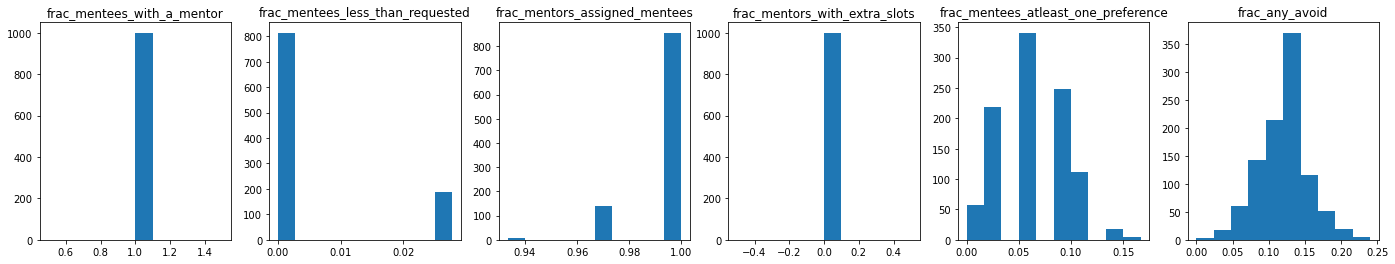

In [17]:
fig,axs = plt.subplots(nrows=1,ncols=6)
for i,ax in enumerate(axs):
    ax.hist(vals[i])
    ax.set_title(names[i])
fig.set_size_inches(24,4)

In [19]:
people,network = generate_network(names_df,mentees_df,mentors_df,loud=False)

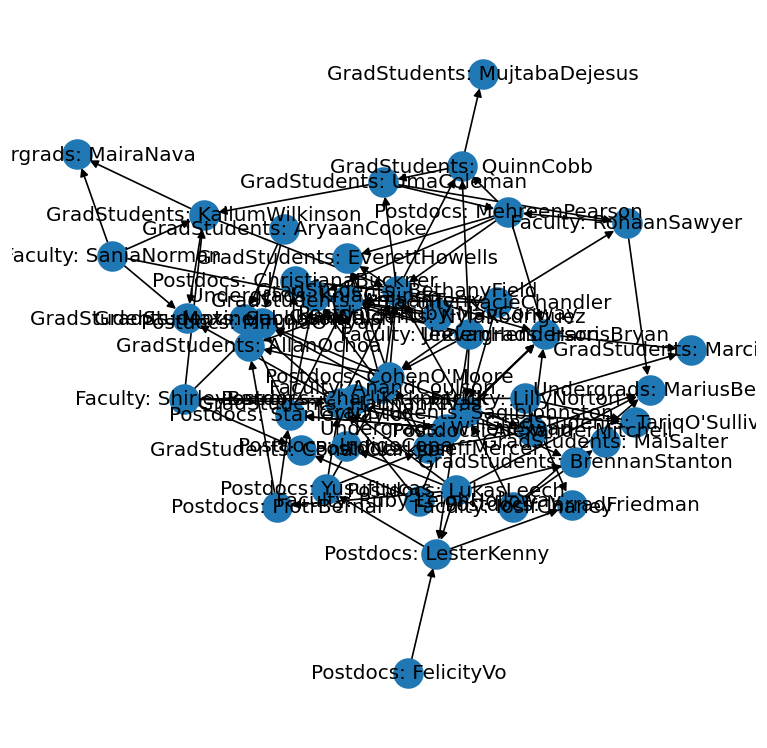

In [20]:
fig,ax = plt.subplots(1,1)
foo = nx.draw_kamada_kawai(network,ax=ax,with_labels=True)
fig.set_size_inches(8,8)
fig.set_dpi(120)